In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'  # 设置日志级别为ERROR，以减少警告信息
# 禁用 Gemini 的底层库（gRPC 和 Abseil）在初始化日志警告
os.environ["GRPC_VERBOSITY"] = "ERROR"
os.environ["GLOG_minloglevel"] = "3"  # 0: INFO, 1: WARNING, 2: ERROR, 3: FATAL
os.environ["GLOG_minloglevel"] = "true"
import logging
import tensorflow as tf
tf.get_logger().setLevel(logging.ERROR)
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
!export TF_FORCE_GPU_ALLOW_GROWTH=true

In [2]:
# Copyright 2019 The TensorFlow Authors.
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

In [3]:
#@title MIT License
#
# Copyright (c) 2017 François Chollet
#
# Permission is hereby granted, free of charge, to any person obtaining a
# copy of this software and associated documentation files (the "Software"),
# to deal in the Software without restriction, including without limitation
# the rights to use, copy, modify, merge, publish, distribute, sublicense,
# and/or sell copies of the Software, and to permit persons to whom the
# Software is furnished to do so, subject to the following conditions:
#
# The above copyright notice and this permission notice shall be included in
# all copies or substantial portions of the Software.
#
# THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
# IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
# FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL
# THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
# LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING
# FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER
# DEALINGS IN THE SOFTWARE.

# 电影评论文本分类

<table class="tfo-notebook-buttons" align="left">
  <td>     <a target="_blank" href="https://tensorflow.google.cn/tutorials/keras/text_classification"><img src="https://tensorflow.google.cn/images/tf_logo_32px.png"> 在 TensorFlow.org 上查看</a>   </td>
  <td>     <a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs-l10n/blob/master/site/zh-cn/tutorials/keras/text_classification.ipynb"><img src="https://tensorflow.google.cn/images/colab_logo_32px.png">在 Google Colab 中运行</a>   </td>
  <td>     <a target="_blank" href="https://github.com/tensorflow/docs-l10n/blob/master/site/zh-cn/tutorials/keras/text_classification.ipynb"><img src="https://tensorflow.google.cn/images/GitHub-Mark-32px.png">在 GitHub 上查看源代码</a>   </td>
  <td>     <a href="https://storage.googleapis.com/tensorflow_docs/docs-l10n/site/zh-cn/tutorials/keras/text_classification.ipynb"><img src="https://tensorflow.google.cn/images/download_logo_32px.png">下载笔记本</a> </td>
</table>

本教程演示了从存储在磁盘上的纯文本文件开始的文本分类。您将训练一个二元分类器对 IMDB 数据集执行情感分析。在笔记本的最后，有一个练习供您尝试，您将在其中训练一个多类分类器来预测 Stack Overflow 上编程问题的标签。


In [4]:
import matplotlib.pyplot as plt
import os
import re
import shutil
import string
import tensorflow as tf

from tensorflow.keras import layers
from tensorflow.keras import losses


In [5]:
print(tf.__version__)

2.17.0


## 情感分析

此笔记本训练了一个情感分析模型，利用评论文本将电影评论分类为*正面*或*负面*评价。这是一个*二元*（或二类）分类示例，也是一个重要且应用广泛的机器学习问题。

您将使用 [Large Movie Review Dataset](https://ai.stanford.edu/~amaas/data/sentiment/)，其中包含 [Internet Movie Database](https://www.imdb.com/) 中的 50,000 条电影评论文本 。我们将这些评论分为两组，其中 25,000 条用于训练，另外 25,000 条用于测试。训练集和测试集是*均衡的*，也就是说其中包含相等数量的正面评价和负面评价。


### 下载并探索 IMDB 数据集

我们下载并提取数据集，然后浏览一下目录结构。

In [6]:
from pathlib import Path
temp_dir = Path(".temp")
temp_dir.mkdir(parents=True, exist_ok=True)

In [7]:
url = "https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz"

dataset = tf.keras.utils.get_file("aclImdb_v1", url,
                                    untar=True, cache_dir=temp_dir,
                                    cache_subdir='')

# dataset_dir = os.path.join(os.path.dirname(dataset), 'aclImdb')
dataset_dir = Path(dataset).parent/'aclImdb'

In [8]:
train_dir = dataset_dir/'train'
[p.name for p in train_dir.iterdir()]

['labeledBow.feat',
 'neg',
 'pos',
 'unsupBow.feat',
 'urls_neg.txt',
 'urls_pos.txt',
 'urls_unsup.txt',
 'unsup']

`aclImdb/train/pos` 和 `aclImdb/train/neg` 目录包含许多文本文件，每个文件都是一条电影评论。我们来看看其中的一条评论。

In [9]:
sample_file = train_dir/'pos/1181_9.txt'
with open(sample_file) as f:
  print(f.read())

Rachel Griffiths writes and directs this award winning short film. A heartwarming story about coping with grief and cherishing the memory of those we've loved and lost. Although, only 15 minutes long, Griffiths manages to capture so much emotion and truth onto film in the short space of time. Bud Tingwell gives a touching performance as Will, a widower struggling to cope with his wife's death. Will is confronted by the harsh reality of loneliness and helplessness as he proceeds to take care of Ruth's pet cow, Tulip. The film displays the grief and responsibility one feels for those they have loved and lost. Good cinematography, great direction, and superbly acted. It will bring tears to all those who have lost a loved one, and survived.


### 加载数据集

接下来，您将从磁盘加载数据并将其准备为适合训练的格式。为此，您将使用有用的 [text_dataset_from_directory](https://tensorflow.google.cn/api_docs/python/tf/keras/preprocessing/text_dataset_from_directory) 实用工具，它期望的目录结构如下所示。

```
main_directory/
...class_a/
......a_text_1.txt
......a_text_2.txt
...class_b/
......b_text_1.txt
......b_text_2.txt
```

要准备用于二元分类的数据集，磁盘上需要有两个文件夹，分别对应于 `class_a` 和 `class_b`。这些将是正面和负面的电影评论，可以在 `aclImdb/train/pos` 和 `aclImdb/train/neg` 中找到。由于 IMDB 数据集包含其他文件夹，因此您需要在使用此实用工具之前将其移除。

In [10]:
remove_dir = train_dir/'unsup'
shutil.rmtree(remove_dir)

接下来，您将使用 `text_dataset_from_directory` 实用工具创建带标签的 `tf.data.Dataset`。[tf.data](https://tensorflow.google.cn/guide/data) 是一组强大的数据处理工具。

运行机器学习实验时，最佳做法是将数据集拆成三份：[训练](https://developers.google.com/machine-learning/glossary#training_set)、[验证](https://developers.google.com/machine-learning/glossary#validation_set) 和 [测试](https://developers.google.com/machine-learning/glossary#test-set)。

IMDB 数据集已经分成训练集和测试集，但缺少验证集。我们来通过下面的 `validation_split` 参数，使用 80:20 拆分训练数据来创建验证集。

In [11]:
batch_size = 32
seed = 42

raw_train_ds = tf.keras.utils.text_dataset_from_directory(
    train_dir, 
    batch_size=batch_size, 
    validation_split=0.2, 
    subset='training', 
    seed=seed)

Found 25000 files belonging to 2 classes.
Using 20000 files for training.


如上所示，训练文件夹中有 25,000 个样本，您将使用其中的 80%（或 20,000 个）进行训练。稍后您将看到，您可以通过将数据集直接传递给 `model.fit` 来训练模型。如果您不熟悉 `tf.data`，还可以遍历数据集并打印出一些样本，如下所示。

In [12]:
for text_batch, label_batch in raw_train_ds.take(1):
  for i in range(3):
    print("Review", text_batch.numpy()[i])
    print("Label", label_batch.numpy()[i])

Review b'"Pandemonium" is a horror movie spoof that comes off more stupid than funny. Believe me when I tell you, I love comedies. Especially comedy spoofs. "Airplane", "The Naked Gun" trilogy, "Blazing Saddles", "High Anxiety", and "Spaceballs" are some of my favorite comedies that spoof a particular genre. "Pandemonium" is not up there with those films. Most of the scenes in this movie had me sitting there in stunned silence because the movie wasn\'t all that funny. There are a few laughs in the film, but when you watch a comedy, you expect to laugh a lot more than a few times and that\'s all this film has going for it. Geez, "Scream" had more laughs than this film and that was more of a horror film. How bizarre is that?<br /><br />*1/2 (out of four)'
Label 0
Review b"David Mamet is a very interesting and a very un-equal director. His first movie 'House of Games' was the one I liked best, and it set a series of films with characters whose perspective of life changes as they get into 

请注意，评论包含原始文本（带有标点符号和偶尔出现的 HTML 代码，如 `<br/>`）。我们将在以下部分展示如何处理这些问题。

标签为 0 或 1。要查看它们与正面和负面电影评论的对应关系，可以查看数据集上的 `class_names` 属性。


In [13]:
print("Label 0 corresponds to", raw_train_ds.class_names[0])
print("Label 1 corresponds to", raw_train_ds.class_names[1])

Label 0 corresponds to neg
Label 1 corresponds to pos


接下来，您将创建验证数据集和测试数据集。您将使用训练集中剩余的 5,000 条评论进行验证。

注：使用 `validation_split` 和 `subset` 参数时，请确保要么指定随机种子，要么传递 `shuffle=False`，这样验证拆分和训练拆分就不会重叠。

In [14]:
raw_val_ds = tf.keras.utils.text_dataset_from_directory(
    train_dir, 
    batch_size=batch_size, 
    validation_split=0.2, 
    subset='validation', 
    seed=seed)

Found 25000 files belonging to 2 classes.
Using 5000 files for validation.


In [15]:
raw_test_ds = tf.keras.utils.text_dataset_from_directory(
    dataset_dir/'test', 
    batch_size=batch_size)

Found 25000 files belonging to 2 classes.


### 准备用于训练的数据集

接下来，您将使用有用的 `tf.keras.layers.TextVectorization` 层对数据进行标准化、词例化和向量化。

标准化是指对文本进行预处理，通常是移除标点符号或 HTML 元素以简化数据集。词例化是指将字符串分割成词例（例如，通过空格将句子分割成单个单词）。向量化是指将词例转换为数字，以便将它们输入神经网络。所有这些任务都可以通过这个层完成。

正如您在上面看到的，评论包含各种 HTML 代码，例如 `<br />`。`TextVectorization` 层（默认情况下会将文本转换为小写并去除标点符号，但不会去除 HTML）中的默认标准化程序不会移除这些代码。您将编写一个自定义标准化函数来移除 HTML。

注：为了防止[训练-测试偏差](https://developers.google.com/machine-learning/guides/rules-of-ml#training-serving_skew)（也称为训练-应用偏差），在训练和测试时间对数据进行相同的预处理非常重要。为此，可以将 `TextVectorization` 层直接包含在模型中，如本教程后面所示。

In [16]:
def custom_standardization(input_data):
  lowercase = tf.strings.lower(input_data)
  stripped_html = tf.strings.regex_replace(lowercase, '<br />', ' ')
  return tf.strings.regex_replace(stripped_html,
                                  '[%s]' % re.escape(string.punctuation),
                                  '')

<br>接下来，您将创建一个 `TextVectorization` 层。您将使用该层对我们的数据进行标准化、词例化和向量化。您将 `output_mode` 设置为 `int` 以便为每个词例创建唯一的整数索引。

请注意，您使用的是默认拆分函数，以及您在上面定义的自定义标准化函数。您还将为模型定义一些常量，例如显式的最大 `sequence_length`，这会使层将序列填充或截断为精确的 `sequence_length` 值。

In [17]:
max_features = 10000
sequence_length = 250

vectorize_layer = layers.TextVectorization(
    standardize=custom_standardization,
    max_tokens=max_features,
    output_mode='int',
    output_sequence_length=sequence_length)

接下来，您将调用 `adapt` 以使预处理层的状态适合数据集。这会使模型构建字符串到整数的索引。

注：在调用时请务必仅使用您的训练数据（使用测试集会泄漏信息）。

In [18]:
# Make a text-only dataset (without labels), then call adapt
train_text = raw_train_ds.map(lambda x, y: x)
vectorize_layer.adapt(train_text)

我们来创建一个函数来查看使用该层预处理一些数据的结果。

In [19]:
def vectorize_text(text, label):
  text = tf.expand_dims(text, -1)
  return vectorize_layer(text), label

In [20]:
# retrieve a batch (of 32 reviews and labels) from the dataset
text_batch, label_batch = next(iter(raw_train_ds))
first_review, first_label = text_batch[0], label_batch[0]
print("Review", first_review)
print("Label", raw_train_ds.class_names[first_label])
print("Vectorized review", vectorize_text(first_review, first_label))

Review tf.Tensor(b'Silent Night, Deadly Night 5 is the very last of the series, and like part 4, it\'s unrelated to the first three except by title and the fact that it\'s a Christmas-themed horror flick.<br /><br />Except to the oblivious, there\'s some obvious things going on here...Mickey Rooney plays a toymaker named Joe Petto and his creepy son\'s name is Pino. Ring a bell, anyone? Now, a little boy named Derek heard a knock at the door one evening, and opened it to find a present on the doorstep for him. Even though it said "don\'t open till Christmas", he begins to open it anyway but is stopped by his dad, who scolds him and sends him to bed, and opens the gift himself. Inside is a little red ball that sprouts Santa arms and a head, and proceeds to kill dad. Oops, maybe he should have left well-enough alone. Of course Derek is then traumatized by the incident since he watched it from the stairs, but he doesn\'t grow up to be some killer Santa, he just stops talking.<br /><br />T

正如您在上面看到的，每个词例都被一个整数替换了。您可以通过在该层上调用 `.get_vocabulary()` 来查找每个整数对应的词例（字符串）。

In [21]:
print("1287 ---> ",vectorize_layer.get_vocabulary()[1287])
print(" 313 ---> ",vectorize_layer.get_vocabulary()[313])
print('Vocabulary size: {}'.format(len(vectorize_layer.get_vocabulary())))

1287 --->  silent
 313 --->  night
Vocabulary size: 10000


你几乎已经准备好训练你的模型了。作为最后的预处理步骤，你将在训练、验证和测试数据集上应用之前创建的TextVectorization层。

In [22]:
train_ds = raw_train_ds.map(vectorize_text)
val_ds = raw_val_ds.map(vectorize_text)
test_ds = raw_test_ds.map(vectorize_text)

### 配置数据集以提高性能

以下是加载数据时应该使用的两种重要方法，以确保 I/O 不会阻塞。

从磁盘加载后，`.cache()` 会将数据保存在内存中。这将确保数据集在训练模型时不会成为瓶颈。如果您的数据集太大而无法放入内存，也可以使用此方法创建高性能的磁盘缓存，这比许多小文件的读取效率更高。

`prefetch()` 会在训练时将数据预处理和模型执行重叠。

您可以在[数据性能指南](https://tensorflow.google.cn/guide/data_performance)中深入了解这两种方法，以及如何将数据缓存到磁盘。

In [23]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

### 创建模型

是时候创建您的神经网络了：

In [24]:
embedding_dim = 16

In [25]:
model = tf.keras.Sequential([
  layers.Embedding(max_features + 1, embedding_dim),
  layers.Dropout(0.2),
  layers.GlobalAveragePooling1D(),
  layers.Dropout(0.2),
  layers.Dense(1)])

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d        │ ?                      │   0 (unbuilt) │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

层按顺序堆叠以构建分类器：

1. 第一个层是 `Embedding` 层。此层采用整数编码的评论，并查找每个单词索引的嵌入向量。这些向量是通过模型训练学习到的。向量向输出数组增加了一个维度。得到的维度为：`(batch, sequence, embedding)`。要详细了解嵌入向量，请参阅[单词嵌入向量](https://tensorflow.google.cn/text/guide/word_embeddings)教程。
2. 接下来，`GlobalAveragePooling1D` 将通过对序列维度求平均值来为每个样本返回一个定长输出向量。这允许模型以尽可能最简单的方式处理变长输入。
3. 最后一层与单个输出结点密集连接。

### 损失函数与优化器

模型训练需要一个损失函数和一个优化器。由于这是一个二元分类问题，并且模型输出概率（具有 Sigmoid 激活的单一单元层），我们将使用 `losses.BinaryCrossentropy` 损失函数。

现在，配置模型以使用优化器和损失函数：

In [26]:
model.compile(loss=losses.BinaryCrossentropy(from_logits=True),
              optimizer='adam',
              metrics=[tf.metrics.BinaryAccuracy(threshold=0.0)])

### 训练模型

将 `dataset` 对象传递给 fit 方法，对模型进行训练。

In [27]:
epochs = 10
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs)

Epoch 1/10


I0000 00:00:1729736653.040209 3211559 service.cc:146] XLA service 0x7ff5cc046510 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1729736653.040274 3211559 service.cc:154]   StreamExecutor device (0): NVIDIA GeForce RTX 3090, Compute Capability 8.6
I0000 00:00:1729736653.040291 3211559 service.cc:154]   StreamExecutor device (1): NVIDIA GeForce RTX 2080 Ti, Compute Capability 7.5


 62/625 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - binary_accuracy: 0.5149 - loss: 0.6927

I0000 00:00:1729736655.192179 3211559 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


625/625 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - binary_accuracy: 0.5839 - loss: 0.6812 - val_binary_accuracy: 0.7276 - val_loss: 0.6142
Epoch 2/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - binary_accuracy: 0.7579 - loss: 0.5812 - val_binary_accuracy: 0.8058 - val_loss: 0.5011
Epoch 3/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - binary_accuracy: 0.8244 - loss: 0.4678 - val_binary_accuracy: 0.8306 - val_loss: 0.4291
Epoch 4/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - binary_accuracy: 0.8530 - loss: 0.3968 - val_binary_accuracy: 0.8352 - val_loss: 0.3904
Epoch 5/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - binary_accuracy: 0.8662 - loss: 0.3499 - val_binary_accuracy: 0.8526 - val_loss: 0.3592
Epoch 6/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - binary_accuracy: 0.8814 - loss: 0.3168 - val_binary_accuracy: 0.8552 - val_loss: 0.3425
Epoch 7/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - binary_accuracy: 0.8901 - loss: 0.2914 - val_binary_accuracy: 0.8474 - val_loss: 0.3385
Epoch 8/10
625/62

### 评估模型

我们来看一下模型的性能如何。将返回两个值。损失值（loss）（一个表示误差的数字，值越低越好）与准确率（accuracy）。

In [28]:
loss, accuracy = model.evaluate(test_ds)

print("Loss: ", loss)
print("Accuracy: ", accuracy)

782/782 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - binary_accuracy: 0.8558 - loss: 0.3287
Loss:  0.33292046189308167
Accuracy:  0.8543599843978882


这种十分简单的方式实现了约 86% 的准确率。

### 创建准确率和损失随时间变化的图表

`model.fit()` 会返回包含一个字典的 `History` 对象。该字典包含训练过程中产生的所有信息：

In [29]:
history_dict = history.history
history_dict.keys()

dict_keys(['binary_accuracy', 'loss', 'val_binary_accuracy', 'val_loss'])

其中有四个条目：每个条目代表训练和验证过程中的一项监测指标。您可以使用这些指标来绘制用于比较的训练损失和验证损失图表，以及训练准确率和验证准确率图表：

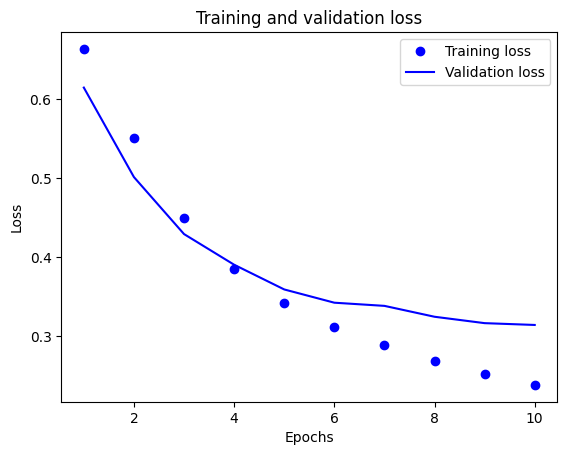

In [30]:
acc = history_dict['binary_accuracy']
val_acc = history_dict['val_binary_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo" is for "blue dot"
plt.plot(epochs, loss, 'bo', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

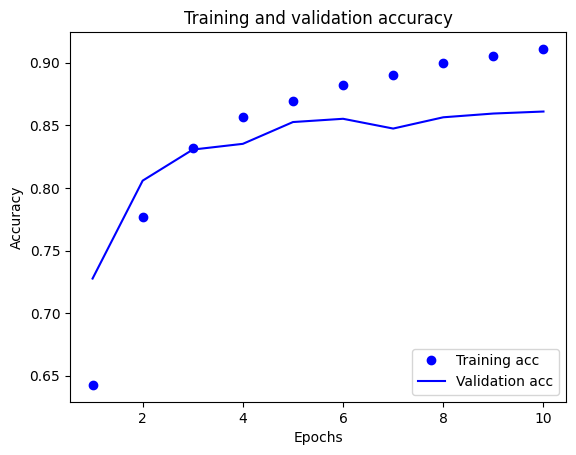

In [31]:
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

plt.show()

在该图表中，虚线代表训练损失和准确率，实线代表验证损失和准确率。

请注意，训练损失会逐周期*下降*，而训练准确率则逐周期*上升*。使用梯度下降优化时，这是预期结果，它应该在每次迭代中最大限度减少所需的数量。

但是，对于验证损失和准确率来说则不然——它们似乎会在训练转确率之前达到顶点。这是过拟合的一个例子：模型在训练数据上的表现要好于在之前从未见过的数据上的表现。经过这一点之后，模型会过度优化和学习*特定*于训练数据的表示，但无法*泛化*到测试数据。

对于这种特殊情况，您可以通过在验证准确率不再增加时直接停止训练来防止过度拟合。一种方式是使用 `tf.keras.callbacks.EarlyStopping` 回调。

## 导出模型

在上面的代码中，您在向模型馈送文本之前对数据集应用了 `TextVectorization`。 如果您想让模型能够处理原始字符串（例如，为了简化部署），您可以在模型中包含 `TextVectorization` 层。为此，您可以使用刚刚训练的权重创建一个新模型。

In [32]:
export_model = tf.keras.Sequential([
  vectorize_layer,
  model,
  layers.Activation('sigmoid')
])

export_model.compile(
    loss=losses.BinaryCrossentropy(from_logits=False), optimizer="adam", metrics=['accuracy']
)

# Test it with `raw_test_ds`, which yields raw strings
results = export_model.evaluate(raw_test_ds)
accuracy = results[-1]
print(accuracy)

782/782 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step - accuracy: 0.8562 - binary_accuracy: 0.0000e+00 - loss: 0.0000e+00
0.8543599843978882


### 使用新数据进行推断

要获得对新样本的预测，只需调用 `model.predict()` 即可。

In [33]:
examples = [
  "The movie was great!",
  "The movie was okay.",
  "The movie was terrible..."
]

export_model.predict(examples)

ValueError: Unrecognized data type: x=['The movie was great!', 'The movie was okay.', 'The movie was terrible...'] (of type <class 'list'>)

将文本预处理逻辑包含在模型中后，您可以导出用于生产的模型，从而简化部署并降低[训练/测试偏差](https://developers.google.com/machine-learning/guides/rules-of-ml#training-serving_skew)的可能性。

在选择应用 TextVectorization 层的位置时，需要注意性能差异。在模型之外使用它可以让您在 GPU 上训练时进行异步 CPU 处理和数据缓冲。因此，如果您在 GPU 上训练模型，您应该在开发模型时使用此选项以获得最佳性能，然后在准备好部署时进行切换，在模型中包含 TextVectorization 层。

请参阅此[教程](https://tensorflow.google.cn/tutorials/keras/save_and_load)，详细了解如何保存模型。

## 练习：对 Stack Overflow 问题进行多类分类

本教程展示了如何在 IMDB 数据集上从头开始训练二元分类器。作为练习，您可以修改此笔记本以训练多类分类器来预测 [Stack Overflow](http://stackoverflow.com/) 上的编程问题的标签。

我们已经准备好了一个[数据集](https://storage.googleapis.com/download.tensorflow.org/data/stack_overflow_16k.tar.gz)供您使用，其中包含了几千个发布在 Stack Overflow 上的编程问题（例如，"How can sort a dictionary by value in Python?"）。每一个问题都只有一个标签（Python、CSharp、JavaScript 或 Java）。您的任务是将问题作为输入，并预测适当的标签，在本例中为 Python。

您将使用的数据集包含从 [BigQuery](https://console.cloud.google.com/marketplace/details/stack-exchange/stack-overflow) 上更大的公共 Stack Overflow 数据集提取的数千个问题，其中包含超过 1700 万个帖子。

下载数据集后，您会发现它与您之前使用的 IMDB 数据集具有相似的目录结构：

```
train/
...python/
......0.txt
......1.txt
...javascript/
......0.txt
......1.txt
...csharp/
......0.txt
......1.txt
...java/
......0.txt
......1.txt
```

注：为了增加分类问题的难度，编程问题中出现的 Python、CSharp、JavaScript 或 Java 等词已被替换为 *blank*（因为许多问题都包含它们所涉及的语言）。

要完成此练习，您应该对此笔记本进行以下修改以使用 Stack Overflow 数据集：

1. 在笔记本顶部，将下载 IMDB 数据集的代码更新为下载前面准备好的 [Stack Overflow 数据集](https://storage.googleapis.com/download.tensorflow.org/data/stack_overflow_16k.tar.gz)的代码。由于 Stack Overflow 数据集具有类似的目录结构，因此您不需要进行太多修改。

2. 将模型的最后一层修改为 `Dense(4)`，因为现在有四个输出类。

3. 编译模型时，将损失更改为 `tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)`。当每个类的标签是整数（在本例中，它们可以是 0、*1*、*2* 或 *3*）时，这是用于多类分类问题的正确损失函数。 此外，将指标更改为 `metrics=['accuracy']`，因为这是一个多类分类问题（`tf.metrics.BinaryAccuracy` 仅用于二元分类器 ）。

4. 在绘制随时间变化的准确率时，请将 `binary_accuracy` 和 `val_binary_accuracy` 分别更改为 `accuracy` 和 `val_accuracy`。

5. 完成这些更改后，就可以训练多类分类器了。 

## 了解更多信息

本教程从头开始介绍了文本分类。要详细了解一般的文本分类工作流程，请查看 Google Developers 提供的[文本分类指南](https://developers.google.com/machine-learning/guides/text-classification/)。
